# Entrenamiento de modelos

## Importaciones

### Librerias básicas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Tratamiento y visualización de datos

In [2]:
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

### Modelos

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

### Funciones auxiliares

In [5]:
from src.predicting_functions import *

Viendo la gran cantidad de celdas que comprenden los datos, se va a optar por usar un modelo GBM ligero. Lo primero que se tiene que decidir es el conjunto de datos que aporta mejores resultados, si es el conjunto inicial, o los datos reducidos por PCA  o los reducidos con UMAP.

### Datos

Datos: PCA


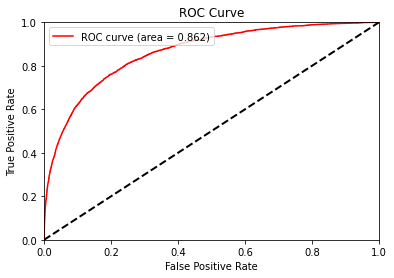

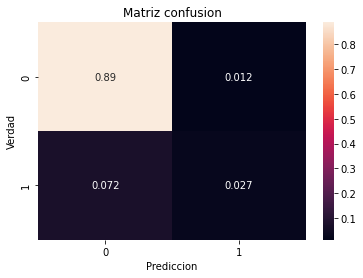

------------------
Datos: UMAP


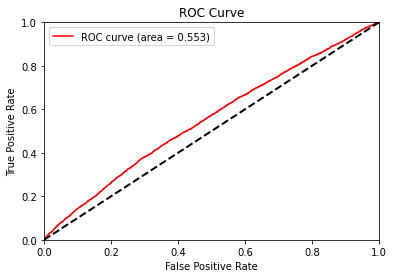

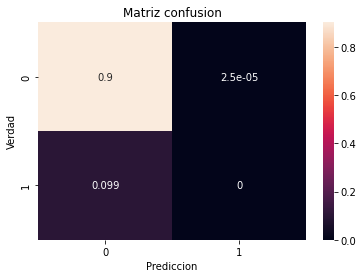

------------------
Datos: sin modificar


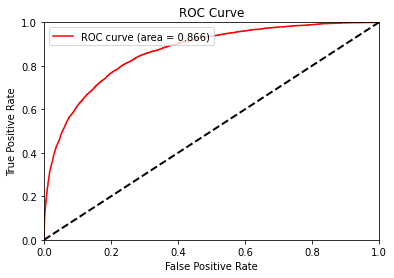

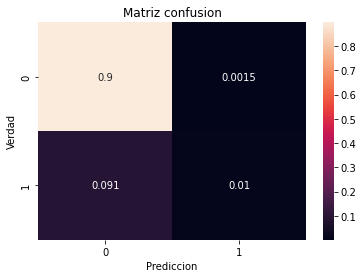

------------------


In [32]:
for e in ["_pca.csv", "_umap.csv", ".csv"]:
    # Importación de los datos
    train = pd.read_csv('./data/train' + e).drop(columns=["ID_code"], errors='ignore')
    test = pd.read_csv('./data/test' + e).drop(columns=["ID_code"], errors='ignore')

    # Separación en parte de train y test
    X_train, X_test, y_train, y_test = train_test(train, test)

    if e!='.csv':
        print("Datos:", e[1:-4].upper())
    else:
        print("Datos: sin modificar")

    # Entrenamiento del modelo
    fpr, tpr, roc_auc, y_pred = reg_model(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)

    # Plot de la curva roc y de la matriz de confusión
    roc_curve_plot(fpr, tpr, roc_auc)
    confusion_matrix_total(y_test, y_pred)
    print('------------------')


Se comprueba como los datos reducidos usando UMAP devuelven unos resultados significativamente peores que los no modificados o que los reducidos con PCA.

Como se puede ver, el modelo está sesgado. Al haber una mayor proporción de filas con valor de target 0 que 1, el modelo tiene muchos falsos negativos. Para solucionar esto hay que balancear los datos.

## Balanceo de datos

El porcentaje de 1 en el targes es: 0.89951
El porcentaje de 0 en el targes es: 0.10049


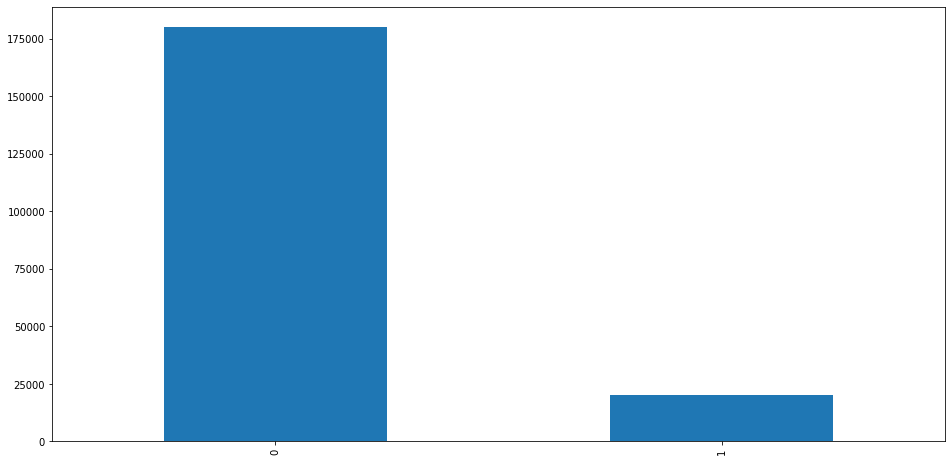

In [ ]:
train.target.value_counts().plot(kind='bar', figsize=(16,8));
print('El porcentaje de 1 en el targes es:', list(train.target.value_counts())[0]/train.shape[0])
print('El porcentaje de 0 en el targes es:', list(train.target.value_counts())[1]/train.shape[0])

In [ ]:
over = RandomOverSampler(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=1)

# fit and apply the under fitting transformation
X_under, y_under = under.fit_resample(train.drop(columns=['target']), train.target)

# fit and apply the over fitting transformation
X_over, y_over = over.fit_resample(train.drop(columns=['target']), train.target)

train_under = pd.concat([y_under, X_under], axis=1)
train_over = pd.concat([y_over, X_over], axis=1)


El porcentaje de 1 en el target es: 0.5
El porcentaje de 0 en el target es: 0.5


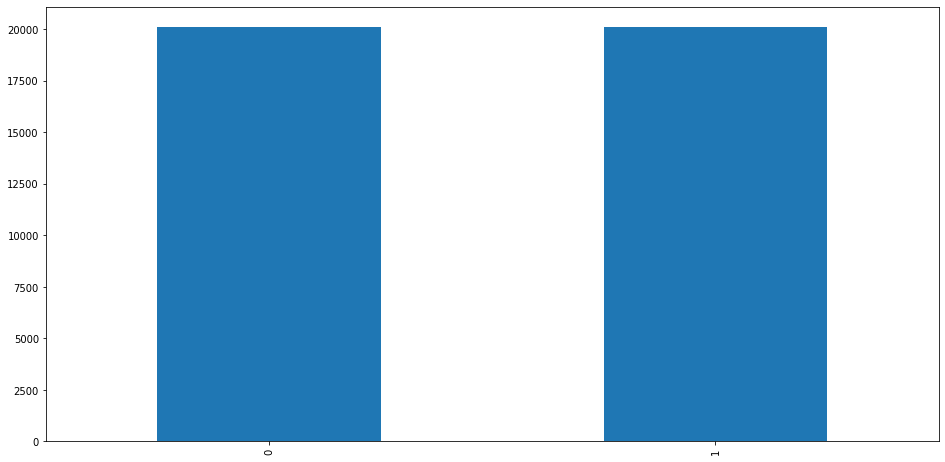

In [ ]:
train_under.target.value_counts().plot(kind='bar', figsize=(16,8));
print('El porcentaje de 1 en el target es:', list(train_under.target.value_counts())[0]/train_under.shape[0])
print('El porcentaje de 0 en el target es:', list(train_under.target.value_counts())[1]/train_under.shape[0])

Ahora ya están los datos balanceados. Se han generado dos dataframes, uno donde se ha hecho over sampler: 'train_over' y otro donde se ha hecho under sampler: 'train_under'

## Split de los datos balanceados

In [ ]:
X_under = train_under.drop(columns=['target'])
y_under = train_under.target


X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2)

In [ ]:
X_over = train_over.drop(columns=['target'])
y_over = train_over.target


X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2)

## Comparción de modelos con dataframe undersampleado y oversampleado

### Undersampleado

In [ ]:
logreg=LogisticRegression(#C=0.01, 
                          tol=0.0001, 
                          max_iter=70,
                          solver='lbfgs', 
                          multi_class='multinomial')

logreg.fit(X=X_train_under, y=y_train_under)

y_pred_under=logreg.predict(X=X_test_under)

train_score=logreg.score(X_train_under, y_train_under)
test_score=logreg.score(X_test_under, y_test_under)

print(logreg)
print('Train:', train_score)
print('Test: ', test_score) 

LogisticRegression(max_iter=70, multi_class='multinomial')
Train: 0.7699029730065928
Test:  0.7728855721393035


/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


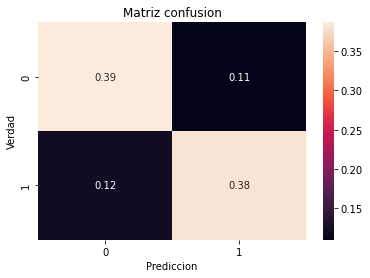

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test_under, y_pred_under)/sum(sum(confusion_matrix(y_test_under, y_pred_under))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
dtc=DecisionTreeClassifier(criterion='entropy', max_depth=6)

dtc.fit(X=X_train_under, y=y_train_under)
y_pred_under=logreg.predict(X=X_test_under)

train_score=dtc.score(X_train_under, y_train_under)  
test_score=dtc.score(X_test_under, y_test_under)

print(dtc)
print('Train:', train_score)
print('Test:', test_score) 

DecisionTreeClassifier(criterion='entropy', max_depth=6)
Train: 0.6219057096653813
Test: 0.6068407960199005


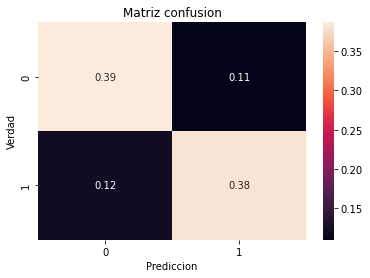

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test_under, y_pred_under)/sum(sum(confusion_matrix(y_test_under, y_pred_under))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

### Oversampleado

In [ ]:
logreg=LogisticRegression(#C=0.01, 
                          tol=0.0001, 
                          max_iter=70,
                          solver='lbfgs', 
                          multi_class='multinomial')

logreg.fit(X=X_train_over, y=y_train_over)

y_pred_over=logreg.predict(X=X_test_over)

train_score=logreg.score(X_train_over, y_train_over)
test_score=logreg.score(X_test_over, y_test_over)

print(logreg)
print('Train:', train_score)
print('Test: ', test_score) 

LogisticRegression(max_iter=70, multi_class='multinomial')
Train: 0.7686342902207106
Test:  0.7658870777226553


/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


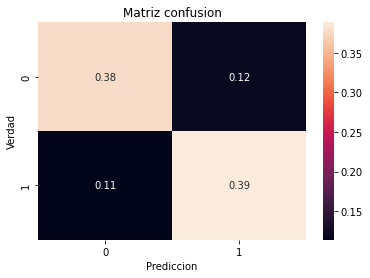

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test_over, y_pred_over)/sum(sum(confusion_matrix(y_test_over, y_pred_over))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
dtc=DecisionTreeClassifier(criterion='entropy', max_depth=6)

dtc.fit(X=X_train_over, y=y_train_over)
y_pred_over=logreg.predict(X=X_test_over)

train_score=dtc.score(X_train_over, y_train_over)  
test_score=dtc.score(X_test_over, y_test_over)

print(dtc)
print('Train:', train_score)
print('Test:', test_score) 

DecisionTreeClassifier(criterion='entropy', max_depth=6)
Train: 0.6261503666929541
Test: 0.6186128597434721


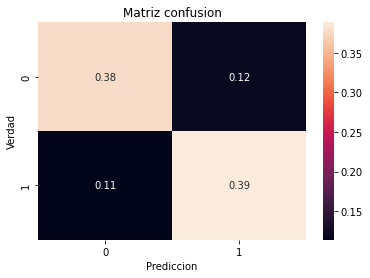

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test_over, y_pred_over)/sum(sum(confusion_matrix(y_test_over, y_pred_over))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

### Conclusiones

Se ha comprobado que los resultados obtenidos con under y over sampling son bastante similares. Por tanto, por razones de optimización y porque no se añaden datos extras se van a entrenar los siguientes modelos con el dataframe under sampleado

In [ ]:
train = pd.concat([y_under, X_under], axis=1)

In [ ]:
train.shape

(40196, 201)

In [ ]:
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,11.4470,-1.3964,9.8012,6.8281,9.9564,-2.7376,6.2276,20.0962,2.8540,...,-4.1293,12.2111,3.3622,6.1279,19.2653,1.9060,-4.2048,10.1548,16.5609,-21.5676
1,0,15.4428,-1.0221,7.5388,5.3376,11.8056,-0.2999,5.2248,14.4918,2.0432,...,-6.5129,6.4216,1.0222,8.9296,19.5367,2.3799,4.9697,10.1797,15.2109,-16.4271
2,0,8.8875,-4.9268,9.9303,8.3236,10.5582,-12.5710,6.2273,13.1349,3.3039,...,2.9672,7.6818,2.2537,2.4904,16.8127,-1.3432,8.3645,10.3720,18.7492,7.4591
3,0,7.7631,-6.4983,12.7748,7.4900,10.7023,-13.6907,6.4808,14.7273,3.8216,...,3.3768,6.0767,3.6012,-5.3905,12.0727,-2.7861,3.6541,8.4755,11.5233,6.4306
4,0,8.6511,-7.2047,10.0985,9.0292,12.9640,-16.9991,5.0096,10.3526,-6.8915,...,-4.5334,9.4711,2.4917,12.2805,20.8884,-0.9244,6.7875,9.1021,21.6111,-4.0350


In [ ]:
X = train.drop(columns=['target'])
y=train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Selección de datos con o sin outliers

### Datos solo con under sampling

In [ ]:
lgbm = LGBMClassifier(n_jobs=-1)

lgbm = lgbm.fit(X_train, y_train,eval_metric='auc',eval_set=(X_test , y_test),verbose=50,early_stopping_rounds= 50)

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.838556	valid_0's binary_logloss: 0.536239
[100]	valid_0's auc: 0.864107	valid_0's binary_logloss: 0.485153


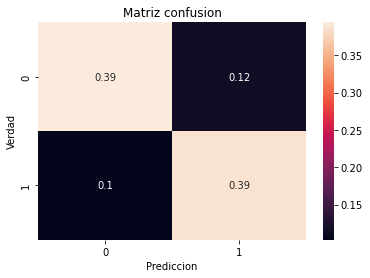

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test, lgbm.predict(X_test))/sum(sum(confusion_matrix(y_test, lgbm.predict(X_test)))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
print( 'Train roc auc score for LGBM en el train: ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print( 'Test roc auc score for LGBM en el test: ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

Train roc auc score for LGBM en el train:  0.9544818202844734
Test roc auc score for LGBM en el test:  0.8641071561223226


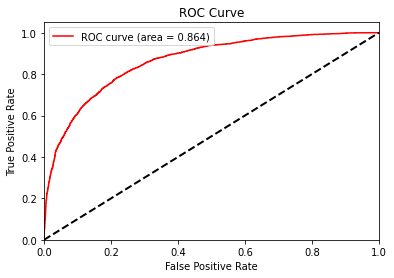

In [ ]:

fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

### Datos con limpieza de ouliers

Ahora se va a probar el mismo modelo pero limpiando outliers alejados mas de 3 desviaciones estandar, para ver si mejora el desempeño

In [ ]:
train[(np.abs(zscore(train.drop(columns=['target']))) < 3).all(axis=1)].shape[0]/train.shape[0]

0.95290576176734

In [ ]:
train_no_outliers_3std = train[(np.abs(zscore(train.drop(columns=['target']))) < 3).all(axis=1)]

In [ ]:
under = RandomUnderSampler(sampling_strategy=1)

# fit and apply the under fitting transformation
X_under, y_under = under.fit_resample(train_no_outliers_3std.drop(columns=['target']), train_no_outliers_3std.target)

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2)

In [ ]:
lgbm = LGBMClassifier(n_jobs=-1)

lgbm = lgbm.fit(X_train, y_train,eval_metric='auc',eval_set=(X_test , y_test),verbose=50,early_stopping_rounds= 50)

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.834868	valid_0's binary_logloss: 0.539596
[100]	valid_0's auc: 0.857968	valid_0's binary_logloss: 0.491033


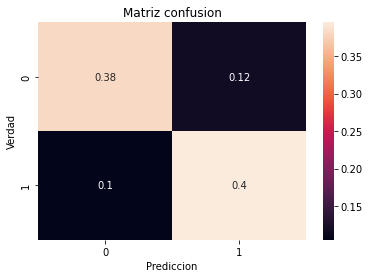

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test, lgbm.predict(X_test))/sum(sum(confusion_matrix(y_test, lgbm.predict(X_test)))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
print( 'Train roc auc score for LGBM en el train: ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print( 'Test roc auc score for LGBM en el test: ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

Train roc auc score for LGBM en el train:  0.9569822589462201
Test roc auc score for LGBM en el test:  0.8579678322476028


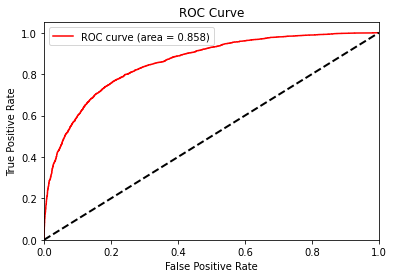

In [ ]:
fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

### Datos con limpieza de outliers más agresiva

Ahora se va a probar el mismo modelo pero limpiando outliers alejados mas de 2.5 desviaciones estandar, para ver si mejora el desempeño

In [ ]:
train[(np.abs(zscore(train.drop(columns=['target']))) < 2.5).all(axis=1)].shape[0]/train.shape[0]

0.4766892228082396

In [ ]:
train_no_outliers_2_5std = train[(np.abs(zscore(train.drop(columns=['target']))) < 2.5).all(axis=1)]

In [ ]:
under = RandomUnderSampler(sampling_strategy=1)

# fit and apply the under fitting transformation
X_under, y_under = under.fit_resample(train_no_outliers_2_5std.drop(columns=['target']), train_no_outliers_2_5std.target)

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2)

In [ ]:
lgbm = LGBMClassifier(n_jobs=-1)

lgbm = lgbm.fit(X_train, y_train,eval_metric='auc',eval_set=(X_test , y_test),verbose=50,early_stopping_rounds= 50)

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.830711	valid_0's binary_logloss: 0.538834
[100]	valid_0's auc: 0.85297	valid_0's binary_logloss: 0.492732


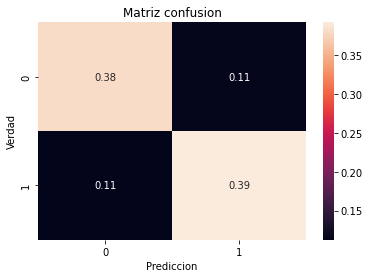

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test, lgbm.predict(X_test))/sum(sum(confusion_matrix(y_test, lgbm.predict(X_test)))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
print( 'Train roc auc score for LGBM en el train: ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print( 'Test roc auc score for LGBM en el test: ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

Train roc auc score for LGBM en el train:  0.9875859333270892
Test roc auc score for LGBM en el test:  0.8529696361575345


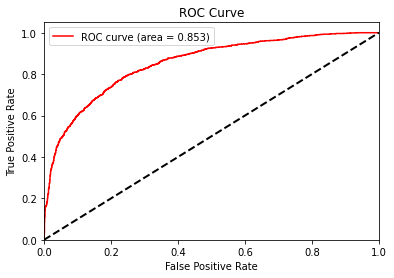

In [ ]:
fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

Se comprueba como el mejor desempeño se logra con los datos sin limpiar outliers

## Selección de datos con o sin reducción de dimensiones

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.864231	valid_0's binary_logloss: 0.459135
[100]	valid_0's auc: 0.864539	valid_0's binary_logloss: 0.458118


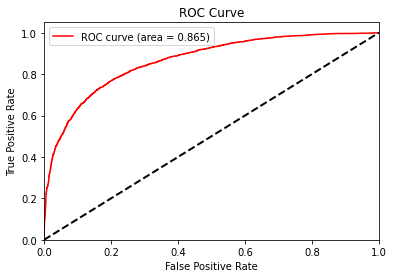

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.856841	valid_0's binary_logloss: 0.470271
[100]	valid_0's auc: 0.857959	valid_0's binary_logloss: 0.46859


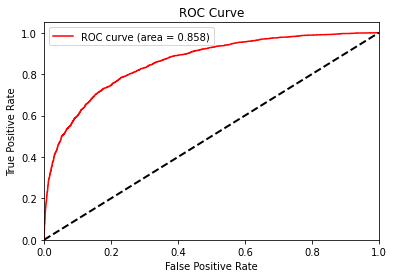

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.833776	valid_0's binary_logloss: 0.538232
[100]	valid_0's auc: 0.860179	valid_0's binary_logloss: 0.48846


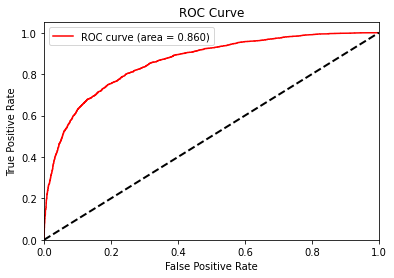

In [ ]:
for e in ['train_pca', 'train_pca', 'train_modified']:
    function_prueba_datos(e)

Se comprueba como el conjunto de datos que mejores resultados aporta es el dataframe sin reducir dimensiones, símplemente con un under sampling

## Modelos

### Lightgbm

In [ ]:
# Selección de datos para entrenar el modelo
train = pd.read_csv('/media/rodrigo/Rodrigo/train_modified.csv')

# Balanceo de datos
under = RandomUnderSampler(sampling_strategy=0.15)
over = RandomOverSampler(sampling_strategy=1)
X, y = under.fit_resample(train.drop(columns=['target']), train.target)
X, y = over.fit_resample(X, y)

# Split de datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Posibles parámetros para entrenar el modelo

params={'num_leaves' : hp.quniform('num_leaves', 1, 100, 2),

        'max_depth' : hp.quniform('max_depth', 1, 100, 2),

        'learning_rate' : hp.uniform('learning_rate', 0.0001, 1),

        'n_estimators': hp.quniform('n_estimators', 10, 1000, 25),

        'subsample':hp.uniform('subsample', 0.7, 1),
        
        'reg_lambda': hp.uniform('reg_lambda', 0, 1),

        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
        }

In [ ]:
# Función para obtener la mejor conbinación de parámetros posible para el modelo

def objetivo(params):
    
    modelo=LGBMClassifier(num_leaves=int(params['num_leaves']),
                max_depth=int(params['max_depth']),
                learning_rate=params['learning_rate'],
                n_estimators=int(params['n_estimators']),
                subsample=params['subsample'],
                min_child_weight=params['min_child_weight'],
                reg_lambda=params['reg_lambda'])
                    
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    modelo.fit(X_train, y_train,
               eval_set=eval_set,
               eval_metric='auc',
               verbose=False)
    
    y_pred=modelo.predict(X_test)
    
    rmse=mse(y_test, y_pred, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
best=fmin(fn=objetivo,
          space=params,
          algo=tpe.suggest,
          max_evals=25,
          trials=Trials())

best

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



  4%|▍         | 1/25 [03:46<1:30:25, 226.06s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



  8%|▊         | 2/25 [04:07<40:36, 105.95s/trial, best loss: 0.15198411002031073]  

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 12%|█▏        | 3/25 [04:40<26:36, 72.55s/trial, best loss: 0.15198411002031073] 

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 16%|█▌        | 4/25 [08:02<43:13, 123.52s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 20%|██        | 5/25 [08:52<32:22, 97.13s/trial, best loss: 0.15198411002031073] 

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 24%|██▍       | 6/25 [09:47<26:13, 82.84s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 28%|██▊       | 7/25 [10:16<19:33, 65.17s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 32%|███▏      | 8/25 [13:51<31:59, 112.91s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 36%|███▌      | 9/25 [14:18<22:54, 85.88s/trial, best loss: 0.15198411002031073] 

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 40%|████      | 10/25 [15:58<22:35, 90.36s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 44%|████▍     | 11/25 [16:08<15:18, 65.60s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 48%|████▊     | 12/25 [16:26<11:05, 51.21s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 52%|█████▏    | 13/25 [17:44<11:53, 59.46s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 56%|█████▌    | 14/25 [18:30<10:09, 55.39s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 60%|██████    | 15/25 [19:13<08:35, 51.55s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 64%|██████▍   | 16/25 [19:52<07:09, 47.75s/trial, best loss: 0.15198411002031073]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 68%|██████▊   | 17/25 [21:44<08:57, 67.20s/trial, best loss: 0.1516153651744844] 

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 72%|███████▏  | 18/25 [23:04<08:16, 70.93s/trial, best loss: 0.1516153651744844]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 76%|███████▌  | 19/25 [25:20<09:03, 90.52s/trial, best loss: 0.1516153651744844]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 80%|████████  | 20/25 [25:42<05:50, 70.05s/trial, best loss: 0.1516153651744844]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 84%|████████▍ | 21/25 [27:52<05:51, 87.97s/trial, best loss: 0.1516153651744844]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 88%|████████▊ | 22/25 [29:23<04:26, 88.88s/trial, best loss: 0.1516153651744844]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 92%|█████████▏| 23/25 [32:27<03:54, 117.41s/trial, best loss: 0.15006917582685658]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



 96%|█████████▌| 24/25 [35:14<02:12, 132.39s/trial, best loss: 0.14932131813644248]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



100%|██████████| 25/25 [36:45<00:00, 88.22s/trial, best loss: 0.14932131813644248] 


{'learning_rate': 0.33991900256629426,
 'max_depth': 96.0,
 'min_child_weight': 4.0,
 'n_estimators': 850.0,
 'num_leaves': 86.0,
 'reg_lambda': 0.7576585038407783,
 'subsample': 0.8263877505951435}

In [ ]:
lgbm =LGBMClassifier(num_leaves=int(best['num_leaves']),
        max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'],
        n_estimators=int(best['n_estimators']),
        subsample=best['subsample'],
        min_child_weight=best['min_child_weight'],
        reg_lambda=best['reg_lambda'])

# lgbm = lgbm.fit(X_train, y_train, eval_metric='auc', eval_set=(X_test , y_test), verbose=30, early_stopping_rounds= 50)

lgbm = lgbm.fit(X_train, y_train, eval_metric='auc', eval_set=(X_test , y_test), verbose=30, early_stopping_rounds= 50)

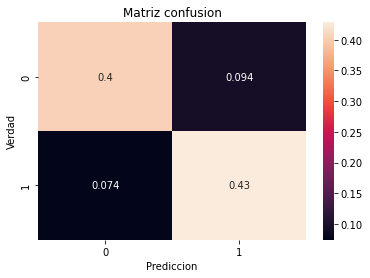

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test, lgbm.predict(X_test))/sum(sum(confusion_matrix(y_test, lgbm.predict(X_test)))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
print( 'Train roc auc score for LGBM en el train: ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print( 'Test roc auc score for LGBM en el test: ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

Train roc auc score for LGBM en el train:  0.9283486350190292
Test roc auc score for LGBM en el test:  0.9128694842570663


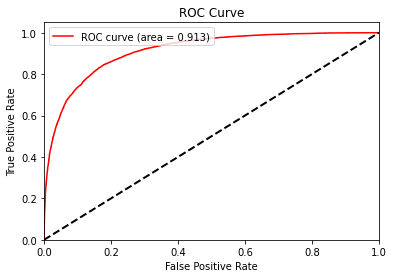

In [ ]:

fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Predicción del modelo

sample = pd.read_csv('/media/rodrigo/Rodrigo/sample_submission.csv')

test =  pd.read_csv('/media/rodrigo/Rodrigo/test_modified.csv')

sample.target=lgbm.predict(test)

sample.to_csv('/media/rodrigo/Rodrigo/sample_submission.csv', index=False)

### Catboost

In [ ]:
# Selección de datos para entrenar el modelo
train = pd.read_csv('/media/rodrigo/Rodrigo/train_modified.csv')

# Balanceo de datos
under = RandomUnderSampler(sampling_strategy=0.15)
over = RandomOverSampler(sampling_strategy=1)
X, y = under.fit_resample(train.drop(columns=['target']), train.target)
X, y = over.fit_resample(X, y)

# Split de datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
cat_boost = CatBoostClassifier(eval_metric = 'AUC')

cat_boost = cat_boost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=70,verbose=50)

Learning rate set to 0.12608
0:	test: 0.8458902	best: 0.8458902 (0)	total: 116ms	remaining: 1m 56s
50:	test: 0.8696400	best: 0.8696400 (50)	total: 5.44s	remaining: 1m 41s
100:	test: 0.8790880	best: 0.8790880 (100)	total: 10.4s	remaining: 1m 32s
150:	test: 0.8891814	best: 0.8891814 (150)	total: 15.4s	remaining: 1m 26s
200:	test: 0.8984666	best: 0.8984666 (200)	total: 20.3s	remaining: 1m 20s
250:	test: 0.9067411	best: 0.9067411 (250)	total: 25.3s	remaining: 1m 15s
300:	test: 0.9143594	best: 0.9143594 (300)	total: 30.4s	remaining: 1m 10s
350:	test: 0.9209681	best: 0.9209681 (350)	total: 35.8s	remaining: 1m 6s
400:	test: 0.9274333	best: 0.9274333 (400)	total: 40.9s	remaining: 1m 1s
450:	test: 0.9333185	best: 0.9333185 (450)	total: 46.2s	remaining: 56.3s
500:	test: 0.9385798	best: 0.9385798 (500)	total: 51.3s	remaining: 51.1s
550:	test: 0.9435463	best: 0.9435463 (550)	total: 56.1s	remaining: 45.8s
600:	test: 0.9478856	best: 0.9478856 (600)	total: 1m 1s	remaining: 40.6s
650:	test: 0.9519292	

In [ ]:
# Predicción del modelo

sample = pd.read_csv('/media/rodrigo/Rodrigo/sample_submission.csv')

test =  pd.read_csv('/media/rodrigo/Rodrigo/test_modified.csv')

sample.target=cat_boost.predict(test)

sample.to_csv('/media/rodrigo/Rodrigo/sample_submission.csv', index=False)

### h20

In [ ]:
# Selección de datos para entrenar el modelo
train = pd.read_csv('/media/rodrigo/Rodrigo/train_modified.csv')

# Balanceo de datos
under = RandomUnderSampler(sampling_strategy=0.15)
over = RandomOverSampler(sampling_strategy=1)
X, y = under.fit_resample(train.drop(columns=['target']), train.target)
X, y = over.fit_resample(X, y)
train = pd.concat([y, X], axis = 1)


# Split de datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def h2o_function(n_models ):
    h2o.init()

    train_h2o = h2o.H2OFrame(train)
    test_h2o = h2o.H2OFrame(test)

    X=train_h2o.columns
    y='target'
    X.remove(y)

    train_h2o[y] = train_h2o[y].asfactor()

    aml=H2OAutoML(max_models = (n_models))

    aml.train(x=X, y=y, training_frame=train_h2o)
    
    return aml.leader.predict(test_h2o).as_data_frame()

In [ ]:
solucion = h2o_function(5)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpep9usfry
  JVM stdout: /tmp/tmpep9usfry/h2o_rodrigo_started_from_python.out
  JVM stderr: /tmp/tmpep9usfry/h2o_rodrigo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"21 days, 18 hours and 51 minutes"
H2O_cluster_name:,H2O_from_python_rodrigo_27dc4q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.680 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
solucion.predict.value_counts()

In [ ]:
sample.target = solucion.predict
sample.to_csv('/media/rodrigo/Rodrigo/sample_submission.csv', index=False)